In [108]:
import beneath as b
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [60]:
months =  { 
    "January":   1,
    "February":  2,
    "March":     3,
    "April":     4,
    "May":       5,
    "June":      6,
    "July":      7,
    "August":    8,
    "September": 9,
    "October":  10,
    "November": 11,
    "December": 12
}

def get_month_id(m):
    return months[m]

def encode_months(timestamps):
    # Column will be of type str if the dataframe is loaded from csv
    if type(timestamps[0]) == str:
        return timestamps.apply(lambda x: get_month_id(datetime.datetime.fromisoformat(x).strftime("%B")))
    # Column will be of type datetime if the dataframe is queried from beneath
    else:
        return timestamps.apply(lambda x: get_month_id(x.month_name()))

In [4]:
_filter = '{ "num_unique_symbols_title": "1", "timestamp": { "_gte": "2021-01-01", "_lt": "2022-01-31" } }'

In [7]:
# # beneath client for accessing table

# client = b.Client()
# table = await client.find_table("examples/wallstreetbets-analytics/r-wallstreetbets-posts-stock-mentions")
# # cursor = await table.primary_instance.query_index(filter=_filter)
# cursor = await table.primary_instance.query_index()
# record = await cursor.read_all(to_dataframe=True)
# # record.to_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')

In [29]:
record = pd.read_csv('csv/r-wallstreetbets-posts-stock-mentions.csv')

In [30]:
list(record.columns)

['Unnamed: 0',
 'symbol',
 'timestamp',
 'post_id',
 'author',
 'num_mentions_title',
 'num_mentions_body',
 'num_unique_symbols_title',
 'num_unique_symbols_body',
 'length_title',
 'length_body',
 '@meta.timestamp']

In [77]:
month_encoded = encode_months(record['timestamp'])
df = record.drop(columns=['@meta.timestamp', 'post_id','author','timestamp','Unnamed: 0'])
df.insert(loc=0, column='month', value=month_encoded)

In [174]:
# These symbols (stocks) are the top N most frequently-mentioned
top_stonks = dict(df.symbol.value_counts()[:50])

# Drop rows from dataframe df if the symbol is not in top_stonks
symbol_names = list(top_stonks.keys())
df_50 = df[df.symbol.isin(symbol_names)].sort_values(by=['symbol', 'month'])
df_50 = df_50[df_50['month'] > 2]
df_50[:50]

,month,symbol,num_mentions_title,num_mentions_body,num_unique_symbols_title,num_unique_symbols_body,length_title,length_body
226,3,AAPL,1,1,1,1,81,2398
227,3,AAPL,1,0,1,0,24,0
228,3,AAPL,0,1,0,3,19,391
229,3,AAPL,1,0,1,0,109,0
230,3,AAPL,1,0,1,0,109,0
231,3,AAPL,1,0,6,0,68,0
232,3,AAPL,1,0,1,0,81,0
233,3,AAPL,0,1,1,3,24,2450
234,3,AAPL,1,1,1,2,151,3768
235,3,AAPL,1,1,1,2,22,3757


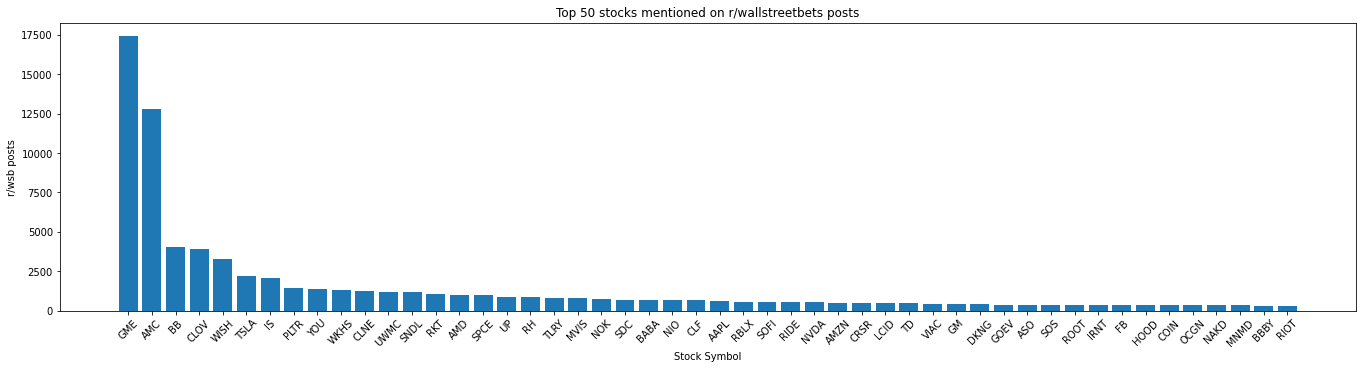

In [182]:
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
symbols = symbol_names
posts = list(top_stonks.values())
ax.bar(symbols, posts)
plt.xlabel("Stock Symbol")
plt.ylabel("r/wsb posts")
plt.title('Top 50 stocks mentioned on r/wallstreetbets posts')
plt.xticks(rotation = 45)
plt.show()

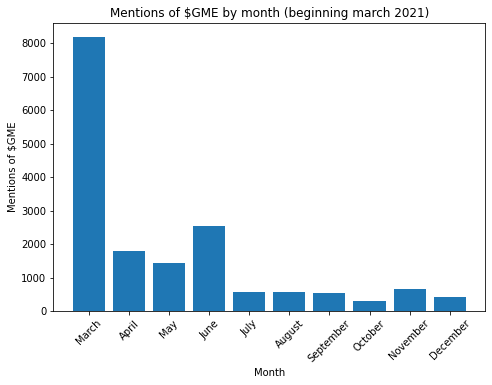

In [187]:
# Let's take a look at mentions of GameStop (GME) by month from March 2021 to Dec 2021
gme_mentions = []

gme = df_50.loc[df['symbol'] == 'GME']
for month in months.values():
    gme_mentions.append(len(gme.loc[df['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
gme_mentions = gme_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], gme_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $GME")
plt.title('Mentions of $GME by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.show()

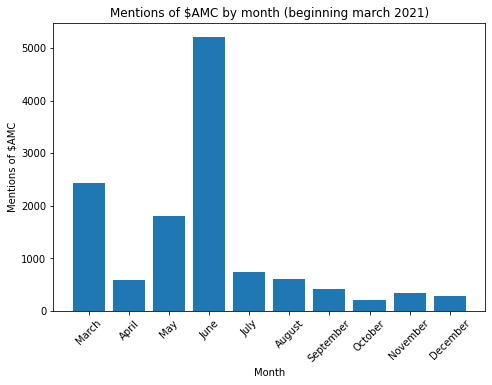

In [188]:
# Let's now take a look at mentions of AMC by month from March 2021 to Dec 2021
amc_mentions = []

amc = df_50.loc[df['symbol'] == 'AMC']
for month in months.values():
    amc_mentions.append(len(amc.loc[df['month'] == month]))
    
# There is no January or February data from this dataset. We will remove the Jan/Feb index as well
# So index 0 of gme_mentions corresponds to March 2021. (beneath started recording data from March 9, 2021)
amc_mentions = amc_mentions[2:]

# Viz
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(months.keys())[2:], amc_mentions)
plt.xlabel("Month")
plt.ylabel("Mentions of $AMC")
plt.title('Mentions of $AMC by month (beginning march 2021)')
plt.xticks(rotation = 45)
plt.show()